In [15]:
import sys
import os

root_path = os.path.abspath('..')
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
functions_path = os.path.abspath('../Functions')
data_path = os.path.abspath('../Data')
algorithms_path = os.path.abspath('../Algorithms')

sys.path.append(functions_path)
sys.path.append(data_path)
sys.path.append(algorithms_path)

import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import time
import stumpy
from stumpy.floss import _rea
from Functions.metrics import f_measure, covering
from Functions.evaluate_floss import evaluate_floss
from Algorithms.floss import floss

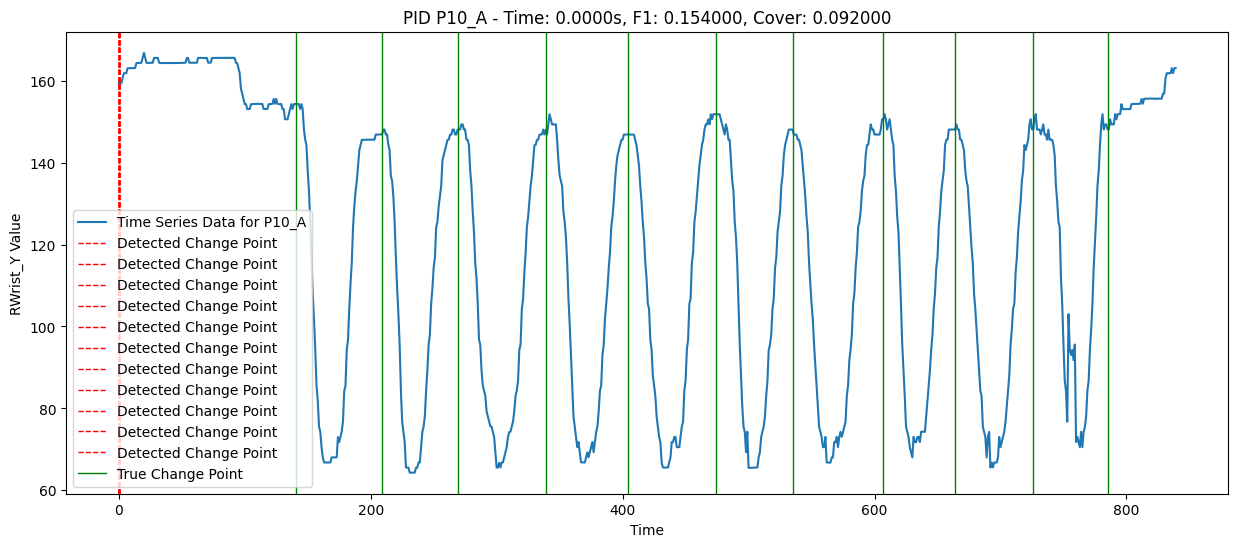

[141, 209, 269, 339, 404, 474, 535, 607, 664, 726, 785]
[0 0 0 0 0 0 0 0 0 0 0]


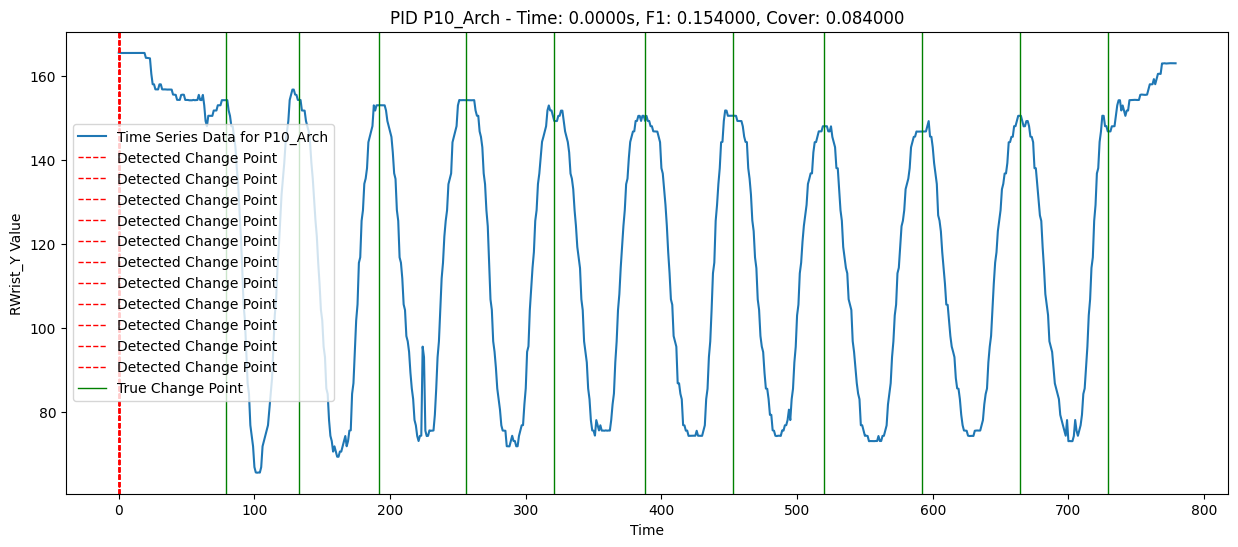

[79, 133, 192, 256, 321, 388, 453, 520, 592, 664, 729]
[0 0 0 0 0 0 0 0 0 0 0]


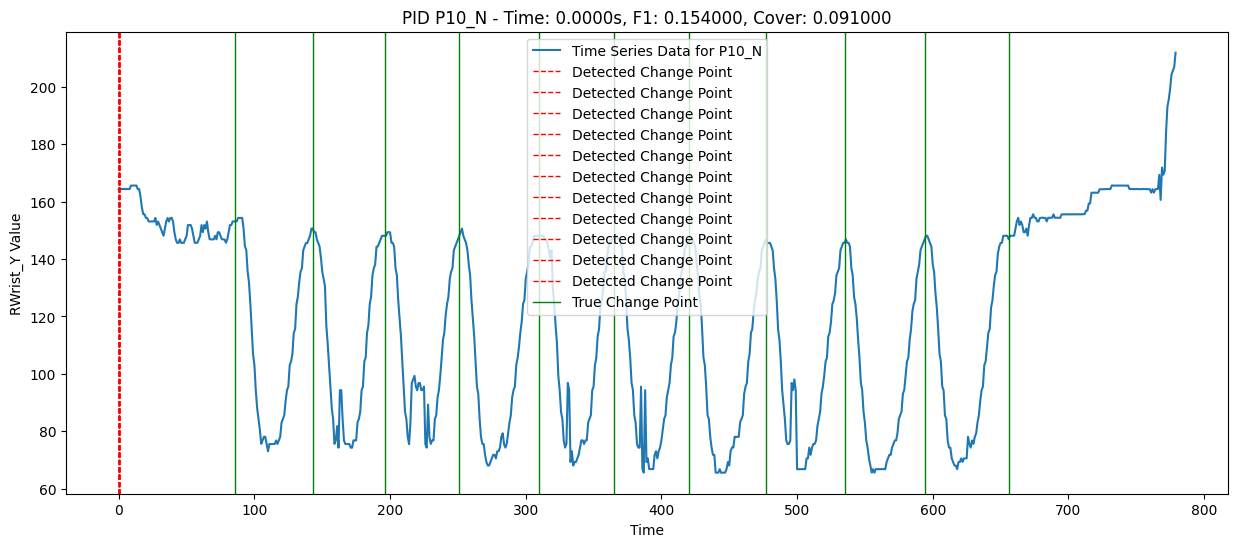

[86, 143, 196, 251, 310, 365, 420, 477, 535, 594, 656]
[0 0 0 0 0 0 0 0 0 0 0]


KeyboardInterrupt: 

In [23]:
# Function to process, plot, and evaluate each PID
def process_plot_evaluate_pid_floss(pid_df, pid, sample_rate, window_size, routine, subject, sensor):
    ts = pid_df["RWrist_Y"].to_numpy()
    frame_peaks = pid_df["frame_peaks"].to_numpy()
    true_change_points = [i for i, peak in enumerate(frame_peaks) if peak == 1]

    start_time = time.time()
    n_cps = len(true_change_points)
    # detected_cps = floss(ts, sample_rate, window_size, n_cps=n_cps, return_cac=False)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # dataset, true_cps, detected_cps, f1_score, covering_score, _ = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)
    _, _, detected_cps, f1_score, covering_score, _ = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)

    plt.figure(figsize=(15, 6))
    plt.plot(ts, label=f'Time Series Data for {pid}')
    for cp in detected_cps:
        plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
    for cp in true_change_points:
        plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
    plt.xlabel('Time')
    plt.ylabel('RWrist_Y Value')
    plt.title(f'PID {pid} - Time: {elapsed_time:.4f}s, F1: {f1_score:.6f}, Cover: {covering_score:.6f}')
    plt.legend()
    plt.show()

    return pid, true_change_points, detected_cps, f1_score, covering_score, elapsed_time

# Load CSV data
csv_file = '..//Data//Physio//OpenPose-RightWristWithoutSegmentation-full_df.csv'
df = pd.read_csv(csv_file)

# Specify parameters for FLoSS
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = 100
window_size = 20

total_time = 0
total_covering = 0
total_f1 = 0
num_pids = 0

f1_scores = []
execution_times = []
coverages = []

for pid, group in df.groupby("pid"):
    result = process_plot_evaluate_pid_floss(group, pid, sample_rate, window_size, routine, subject, sensor)
    print(f"{result[1]}")
    print(f"{result[2]}")

    total_time += result[-1]
    total_covering += result[-2]
    total_f1 += result[-3]
    num_pids += 1
    execution_times.append(result[-1])
    coverages.append(result[-2])
    f1_scores.append(result[-3])

average_time = total_time / num_pids
average_covering = total_covering / num_pids
average_f1 = total_f1 / num_pids

print(f'Average Time: {average_time:.4f}s, Average Coverage: {average_covering:.6f}, Average F1 Score: {average_f1:.6f}')

## Time to refator the data so i can try another method

<class 'numpy.ndarray'>
[159.361 159.35  159.326 160.579 161.808 161.851 161.838 163.047 163.06
 163.051]
[141, 209, 269, 339, 404, 474, 535, 607, 664, 726, 785]
[782 692 172 338 122 469 405 267 599 212 537]


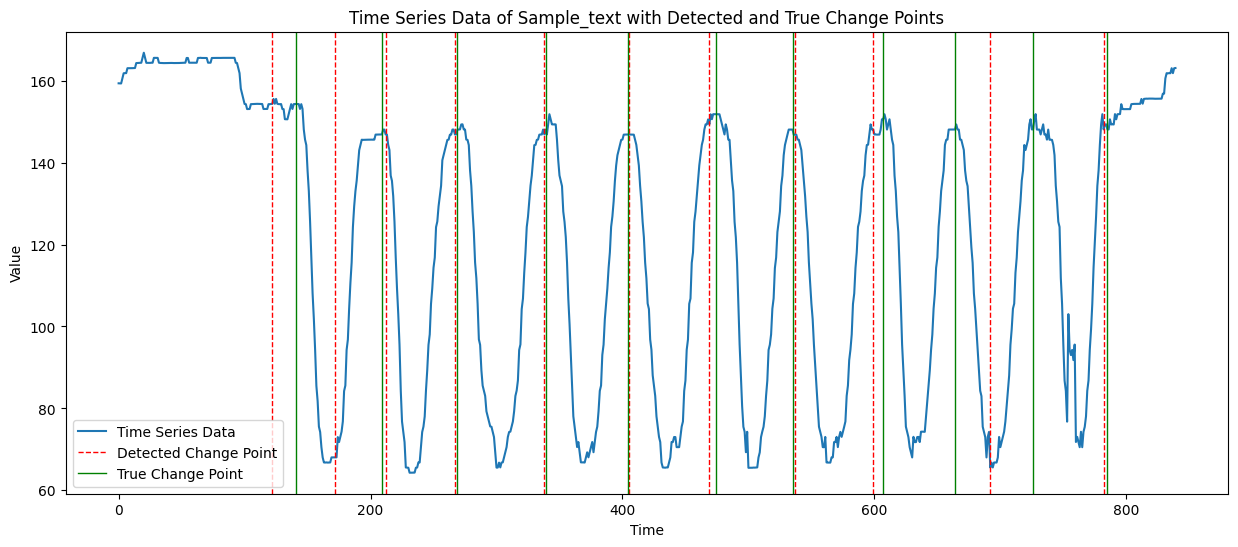

F1 Score: 0.75
Covering Score: 0.79


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from Functions.metrics import f_measure, covering
from Functions.true_cps import read_true_change_points
from Functions.evaluate_floss import evaluate_floss
# from coverage import calculate_coverage_score

## Define the dataset name and other parameters (adjust as necessary)
dataset_name = 'Sample_text'
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = 8

# Load the dataset
data_path = f'..//Data//Physio//{dataset_name}.txt'
data = np.loadtxt(data_path)
print(type(data))
print(data[0:10])

# Read true change points
desc_path = '..//Data//Physio//Sample_tcp_text.txt'
true_change_points = read_true_change_points(desc_path, dataset_name)
print(true_change_points)

# Apply FLOSS and evaluate its performance
_, _, found_cps, f1_score, covering_score, _ = evaluate_floss(
    dataset_name, routine, subject, sensor, sample_rate,
    true_change_points, [], data
)
print(f"{found_cps}")
# Visualization
plt.figure(figsize=(15, 6))  # Adjust the figure size to make it wider
plt.plot(data, label='Time Series Data')

# Draw vertical lines for each detected change point
for cp in found_cps:
    plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == found_cps[0] else "")

# Draw vertical lines for each true change point
for cp in true_change_points:
    plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series Data of {dataset_name} with Detected and True Change Points')
plt.legend()
plt.show()

# Print the performance metrics
print(f"F1 Score: {f1_score}")
print(f"Covering Score: {covering_score}")

In [ ]:
data_path = f'..//Data//Physio//{dataset_name}.txt'